In [6]:
# Every parameter to be modified is here

# Image directory
directory = 'data/'
ext = '.tif'
file_name = 'RGB-IR-G4'
image_file = directory + file_name + ext

# Colormap
color_map = 'gist_gray'

saved_params = file_name + '_saved_params'

In [7]:
# Editor appearance set up & Load plot

# Change backend for interactive plot
%matplotlib nbagg
# %matplotlib osx
# %matplotlib tk
# %matplotlib qt

# This line of "print" must exist right after %matplotlib command, 
# otherwise JN will hang on the first import statement after this.
print('Interactive plot activated')


# Extend width of Jupyter Notebook Cell to the size of browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# Import packages needed

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from matplotlib.widgets  import RectangleSelector, PolygonSelector
import numpy as np
from skimage import io
import mplcursors
import IPython.display as Disp
from ipywidgets import widgets
import cv2
from osgeo import gdal
import pickle


# Load image and print size & pre-process

# Use skimage to load multi-layer tiff file
rgb_ir_img = io.imread(image_file)
print("Image Shape: ", rgb_ir_img.shape)

# Extract layers from the multilayer tiff file and do some adjustments
layer_RGB = np.copy(rgb_ir_img[:, :, 0:3])
layer_IR = np.copy(rgb_ir_img[:, :, 3])
layer_mask = np.copy(rgb_ir_img[:, :, 4])

# Change from 16 bit to 8 bit(max 65535 to max 255)
layer_RGB = np.round(layer_RGB / 257)
layer_RGB = layer_RGB.astype(int)

# Set background to black (You can choose background color when exporting orthomosaic from agisoft, 
# the default is white)
layer_RGB[np.where(layer_mask == 0)] = 0
layer_IR[np.where(layer_mask == 0)] = 0



# Load GPS coordinate from file & Calculate pixel location

with open(saved_params, 'rb') as f:
    plot_names = pickle.load(f)
    plot_vertices_gps = pickle.load(f)
    
# Calculating pixel location from GPS coordinate

ds = gdal.Open(image_file)
gt = ds.GetGeoTransform()
a, b, c, d, e, f = gt

plot_vertices = []
for i in range(len(plot_vertices_gps)):
    one_plot_vertices_gps = plot_vertices_gps[i]
    one_plot_vertices = []
    for vertex in one_plot_vertices_gps:
        xgeo, ygeo = vertex
        
        x = (xgeo - a) / b
        y = (ygeo - d) / f

        one_plot_vertices.append([x, y])
    one_plot_vertices = np.array(one_plot_vertices)
    one_plot_vertices = np.round(one_plot_vertices)
    one_plot_vertices = one_plot_vertices.astype(int)
    plot_vertices.append(one_plot_vertices)

print('Plot location loaded')

Interactive plot activated


Image Shape:  (9171, 5093, 5)
Plot location loaded


<IPython.core.display.Javascript object>


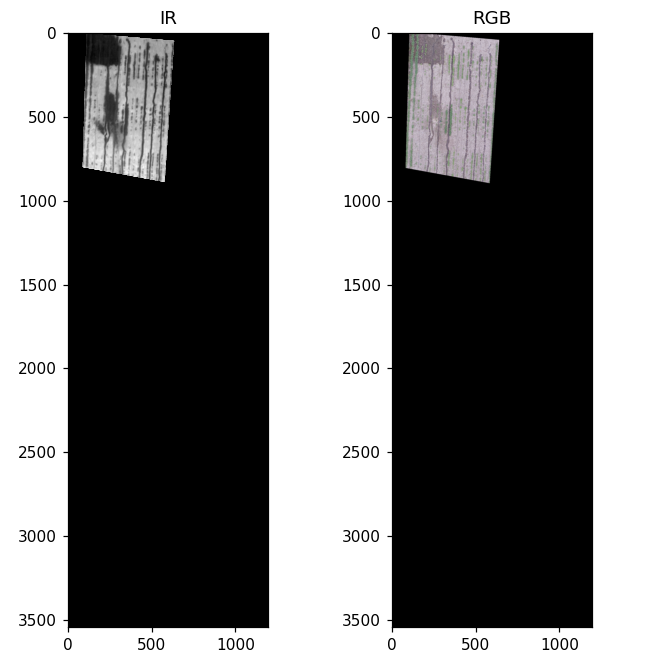

In [8]:
# Show plots

import matplotlib.pyplot as plt

from skimage.draw import line, polygon, circle, ellipse
import numpy as np


all_points = np.concatenate(plot_vertices, axis=0)
mins = np.amin(all_points, axis=0)
maxs = np.amax(all_points, axis=0)

plot_1_vertices = plot_vertices[0]
rr, cc = polygon(plot_1_vertices[:,1], plot_1_vertices[:,0], layer_IR.shape)
mask = np.zeros(layer_IR.shape, np.float)
mask[rr, cc] = 1
interested_area_mask_IR = mask[mins[1]:maxs[1], mins[0]:maxs[0]]
interested_area_IR = layer_IR[mins[1]:maxs[1], mins[0]:maxs[0]]
interested_area_RGB = layer_RGB[mins[1]:maxs[1], mins[0]:maxs[0], :]

plot_1_IR = np.multiply(interested_area_IR, interested_area_mask_IR)

interested_area_mask_RGB = interested_area_mask_IR.astype('int32')

for i in range(3):
    interested_area_RGB[:, :, i] *= interested_area_mask_RGB

fig, axs = plt.subplots(1, 2, figsize=(6, 6))
fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95)
axs[0].set_title('IR')
axs[1].set_title('RGB')

inds = np.where(interested_area_mask_IR > 0)
vmin = interested_area_IR[inds].min()
vmax = interested_area_IR[inds].max()
axim0 = axs[0].imshow(plot_1_IR, cmap=plt.get_cmap(color_map), vmin=vmin, vmax=vmax)
axim1 = axs[1].imshow(interested_area_RGB)

plt.show()

In [36]:
inds = np.where(interested_area_mask_IR > 0)
avg_IR = np.average(interested_area_IR[inds])
avg_temp = avg_IR * 0.04 - 273.15
print("The average temp in your specified area was")
print(avg_temp, '℃')

The average temp in your specified area was
41.23013606021573 ℃
